In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import random

In [2]:
# Set seed for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set seed
set_seed(42)

In [3]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Logistic

In [4]:
class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    #classes = ['untreated', 'single_dose', 'drug_screened']
    classes = ['cond7_all', 'sd','ex']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"G:\classification"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

class LabeledImageDataset(Dataset):
    def __init__(self, image_files, labels, transform=None):
        self.image_files = image_files
        self.labels = labels
        self.transform = transform
        self.resize_transform = transforms.Resize((96, 96))

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = self.image_files[idx]
        image = tiff.imread(img_path)

        # Ensure the image has 3 layers (channels)
        if image.shape[0] != 3:
            raise ValueError(f"Image {img_path} does not have exactly 3 layers.")

        # Normalize the 16-bit image to [0, 1]
        image = image.astype(np.float32) / 65535.0

        # Convert to a torch tensor and add channel dimension
        image = torch.tensor(image, dtype=torch.float32)
        
        # Apply resize transform
        image = self.resize_transform(image)

        label = self.labels[idx]

        return image, label

def load_and_split_data(root_dir, test_size=0.2):
    #classes = ['untreated', 'single_dose', 'drug_screened']
    classes = ['ex', 'sd', 'cond7_all']
    image_files = []
    labels = []

    for idx, class_name in enumerate(classes):
        class_dir = os.path.join(root_dir, class_name)
        files = [os.path.join(class_dir, file) for file in os.listdir(class_dir) if file.endswith(('.tiff', '.tif'))]
        image_files.extend(files)
        labels.extend([idx] * len(files))
    
    # Check if the labels correctly reflect the classes
    #print("Label distribution:", {classes[i]: labels.count(i) for i in range(len(classes))})
    
    # Split data into training and test sets
    train_files, test_files, train_labels, test_labels = train_test_split(
        image_files, labels, test_size=test_size, stratify=labels, random_state=42)

    return train_files, test_files, train_labels, test_labels


# Directories for labeled data
image_dir = r"C:\Users\k54739\Bibi_new_thesis\thesis\classification"

# Load and split the data
train_files, test_files, train_labels, test_labels = load_and_split_data(image_dir, test_size=0.2)

# Create the labeled datasets
train_labeled_dataset = LabeledImageDataset(train_files, train_labels)
test_labeled_dataset = LabeledImageDataset(test_files, test_labels)

# Define DataLoaders
batch_size = 16
train_loader_labeled = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True, drop_last=False, pin_memory=True, num_workers=0)
test_loader_labeled = DataLoader(test_labeled_dataset, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=0)

In [5]:
for anchor,label in train_loader_labeled:
    print(anchor.shape, label.shape, anchor.dtype)
    print(label)
    break

torch.Size([16, 3, 96, 96]) torch.Size([16]) torch.float32
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])


In [6]:
all_labels = []

for _, labels in train_loader_labeled:
    print(labels)  # Print the labels for each batch
    all_labels.extend(labels.tolist())  # Collect all labels in a list

# If you want to print all labels as a single list after the loop
print("All Labels:", all_labels)


tensor([0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0])
tensor([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1])
tensor([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])
tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1])
tensor([0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1])
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0])
tensor([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 2, 0])
tensor([0, 0, 0, 0, 0, 0, 2, 2, 1, 0, 1, 0, 0, 0, 0, 0])
tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
tensor([1, 0, 0, 1, 1, 0, 2, 1,

In [7]:
unique_labels = set()

for _, labels in train_loader_labeled:
    unique_labels.update(labels.tolist())  # Add labels to the set

print("Total unique labels:", len(unique_labels))
print("Unique labels:", unique_labels)


Total unique labels: 3
Unique labels: {0, 1, 2}


In [8]:
from collections import Counter

label_counter = Counter()

# Iterate through training data to count labels
for _, labels in train_loader_labeled:
    label_counter.update(labels.tolist())  # Update the counter with current batch labels

# Iterate through test data to count labels
for _, labels in test_loader_labeled:  # Assuming test_loader_labeled exists
    label_counter.update(labels.tolist())  # Update the counter with current batch labels

# Print counts for each label
for label, count in label_counter.items():
    print(f"Label {label}: {count} occurrences")

# Optionally print the total counts
print("Total counts (Training + Test):", label_counter)


Label 0: 472 occurrences
Label 1: 103 occurrences
Label 2: 40 occurrences
Total counts (Training + Test): Counter({0: 472, 1: 103, 2: 40})


In [9]:
def prepare_data_features(dataloader):
    feats, labels = [], []
    
    for batch_imgs, batch_labels in tqdm(dataloader):
        batch_imgs = batch_imgs.to(device)
        
        # Flatten the images from (N, C, H, W) to (N, C*H*W)
        batch_feats = batch_imgs.view(batch_imgs.size(0), -1)  # Flatten the images
        print(f"Batch features shape: {batch_feats.shape}")  # Check the feature shape
        print(f"Batch labels shape: {batch_labels.shape}")
        
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)
    
    print(f"Features shape after concatenation: {feats.shape}")
    print(f"Labels shape after concatenation: {labels.shape}")

    return torch.utils.data.TensorDataset(feats, labels)


In [10]:
# Extract features for train and test datasets
train_feats = prepare_data_features(train_loader_labeled)
test_feats = prepare_data_features(test_loader_labeled)

  3%|▎         | 1/31 [00:00<00:17,  1.68it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


  6%|▋         | 2/31 [00:01<00:17,  1.64it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 10%|▉         | 3/31 [00:01<00:17,  1.62it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 13%|█▎        | 4/31 [00:02<00:16,  1.66it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 16%|█▌        | 5/31 [00:03<00:15,  1.63it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 19%|█▉        | 6/31 [00:03<00:15,  1.65it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 23%|██▎       | 7/31 [00:04<00:14,  1.63it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 26%|██▌       | 8/31 [00:04<00:14,  1.62it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 29%|██▉       | 9/31 [00:05<00:13,  1.66it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 32%|███▏      | 10/31 [00:06<00:12,  1.62it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 35%|███▌      | 11/31 [00:06<00:12,  1.62it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 39%|███▊      | 12/31 [00:07<00:11,  1.62it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 42%|████▏     | 13/31 [00:07<00:11,  1.61it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 45%|████▌     | 14/31 [00:08<00:10,  1.63it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 48%|████▊     | 15/31 [00:09<00:09,  1.62it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 52%|█████▏    | 16/31 [00:09<00:09,  1.60it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 55%|█████▍    | 17/31 [00:10<00:08,  1.64it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 58%|█████▊    | 18/31 [00:11<00:08,  1.62it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 61%|██████▏   | 19/31 [00:11<00:07,  1.64it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 65%|██████▍   | 20/31 [00:12<00:06,  1.63it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 68%|██████▊   | 21/31 [00:12<00:06,  1.60it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 71%|███████   | 22/31 [00:13<00:05,  1.64it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 74%|███████▍  | 23/31 [00:14<00:04,  1.63it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 77%|███████▋  | 24/31 [00:14<00:04,  1.64it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 81%|████████  | 25/31 [00:15<00:03,  1.64it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 84%|████████▍ | 26/31 [00:15<00:03,  1.62it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 87%|████████▋ | 27/31 [00:16<00:02,  1.65it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 90%|█████████ | 28/31 [00:17<00:01,  1.63it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 94%|█████████▎| 29/31 [00:17<00:01,  1.64it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 97%|█████████▋| 30/31 [00:18<00:00,  1.66it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


100%|██████████| 31/31 [00:18<00:00,  1.64it/s]


Batch features shape: torch.Size([12, 27648])
Batch labels shape: torch.Size([12])
Features shape after concatenation: torch.Size([492, 27648])
Labels shape after concatenation: torch.Size([492])


 12%|█▎        | 1/8 [00:00<00:04,  1.71it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 25%|██▌       | 2/8 [00:01<00:03,  1.63it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 38%|███▊      | 3/8 [00:01<00:03,  1.65it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 50%|█████     | 4/8 [00:02<00:02,  1.64it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 62%|██████▎   | 5/8 [00:03<00:01,  1.61it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 75%|███████▌  | 6/8 [00:03<00:01,  1.65it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


 88%|████████▊ | 7/8 [00:04<00:00,  1.62it/s]

Batch features shape: torch.Size([16, 27648])
Batch labels shape: torch.Size([16])


100%|██████████| 8/8 [00:04<00:00,  1.71it/s]

Batch features shape: torch.Size([11, 27648])
Batch labels shape: torch.Size([11])
Features shape after concatenation: torch.Size([123, 27648])
Labels shape after concatenation: torch.Size([123])


In [11]:
# Logistic Regression model definition
class LogisticRegression(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.linear(x)

In [12]:
# Training function
def train_logistic_regression(model, train_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    for batch_feats, batch_labels in tqdm(train_loader, desc="Training"):
        batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_feats)
        loss = nn.functional.cross_entropy(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        # Update learning rate scheduler
        scheduler.step()

        total_loss += loss.item()

        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [13]:
# Evaluation function
def evaluate_logistic_regression(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_feats, batch_labels in tqdm(test_loader, desc="Evaluating"):
            batch_feats, batch_labels = batch_feats.to(device), batch_labels.to(device)
            
            outputs = model(batch_feats)
            loss = nn.functional.cross_entropy(outputs, batch_labels)
            total_loss += loss.item()

            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

    avg_loss = total_loss / len(test_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, accuracy

In [14]:
def train_logreg_simplified(batch_size, train_feats_data, test_feats_data, feature_dim, num_classes, lr=5e-4, weight_decay=1e-4, max_epochs=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Data loaders
    train_loader = DataLoader(train_feats_data, batch_size=batch_size, shuffle=True,
                              drop_last=False, pin_memory=True, num_workers=0)
    test_loader = DataLoader(test_feats_data, batch_size=batch_size, shuffle=False,
                             drop_last=False, pin_memory=True, num_workers=0)

    # Model, loss, and optimizer
    model = LogisticRegression(feature_dim, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                               milestones=[int(max_epochs * 0.6), int(max_epochs * 0.8)],
                                               gamma=0.1)

    # Store metrics for plotting
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # Track best metrics
    best_train_acc = -1.0
    best_train_epoch = -1

    best_test_acc = -1.0
    best_test_epoch = -1

    best_test_loss = float('inf')
    best_test_loss_acc = -1.0
    best_model_state_loss = None

    for epoch in range(max_epochs):
        print(f"Epoch {epoch+1}/{max_epochs}")

        train_loss, train_acc = train_logistic_regression(model, train_loader, optimizer, scheduler, device)
        test_loss, test_acc = evaluate_logistic_regression(model, test_loader, criterion, device)

        print(f"Training loss: {train_loss:.4f}, Training accuracy: {train_acc:.4f}")
        print(f"Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}")

        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        # Track best train accuracy
        if train_acc > best_train_acc:
            best_train_acc = train_acc
            best_train_epoch = epoch + 1

        # Track best test accuracy
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_test_epoch = epoch + 1

        # Check for best loss model
        # Condition: strictly lower loss OR equal loss but higher accuracy
        if (test_loss < best_test_loss) or (test_loss == best_test_loss and test_acc > best_test_loss_acc):
            best_test_loss = test_loss
            best_test_loss_acc = test_acc
            best_model_state_loss = model.state_dict()

    # Return metrics for plotting
    return {
        "train_losses": train_losses,
        "test_losses": test_losses,
        "train_accuracies": train_accuracies,
        "test_accuracies": test_accuracies,
        "best_train_acc": best_train_acc,
        "best_train_epoch": best_train_epoch,
        "best_test_acc": best_test_acc,
        "best_test_epoch": best_test_epoch
    }




In [15]:
# Train the logistic regression model
results = train_logreg_simplified(
    batch_size=8,
    train_feats_data=train_feats,
    test_feats_data=test_feats,
    feature_dim=train_feats.tensors[0].shape[1],
    num_classes=3,
    lr=5e-4,
    weight_decay=1e-4,
    max_epochs=250
)

# The results dictionary now contains the metrics that you can use to plot in a new cell.

Epoch 1/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 184.88it/s]


Training loss: 0.8249, Training accuracy: 0.8069
Test loss: 0.2351, Test accuracy: 0.9512
Epoch 2/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 361.15it/s]


Training loss: 0.3686, Training accuracy: 0.8801
Test loss: 0.2430, Test accuracy: 0.9024
Epoch 3/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.02it/s]


Training loss: 0.2381, Training accuracy: 0.9431
Test loss: 0.0719, Test accuracy: 0.9837
Epoch 4/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 345.37it/s]


Training loss: 0.0831, Training accuracy: 0.9675
Test loss: 0.0645, Test accuracy: 0.9837
Epoch 5/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 418.24it/s]


Training loss: 0.0829, Training accuracy: 0.9695
Test loss: 0.0647, Test accuracy: 0.9837
Epoch 6/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 429.18it/s]


Training loss: 0.0814, Training accuracy: 0.9715
Test loss: 0.0641, Test accuracy: 0.9837
Epoch 7/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.48it/s]


Training loss: 0.0828, Training accuracy: 0.9675
Test loss: 0.0662, Test accuracy: 0.9837
Epoch 8/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 352.66it/s]


Training loss: 0.0815, Training accuracy: 0.9715
Test loss: 0.0649, Test accuracy: 0.9837
Epoch 9/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 335.80it/s]


Training loss: 0.0818, Training accuracy: 0.9715
Test loss: 0.0656, Test accuracy: 0.9837
Epoch 10/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 359.98it/s]


Training loss: 0.0822, Training accuracy: 0.9715
Test loss: 0.0655, Test accuracy: 0.9837
Epoch 11/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 373.98it/s]


Training loss: 0.0803, Training accuracy: 0.9695
Test loss: 0.0671, Test accuracy: 0.9837
Epoch 12/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 426.28it/s]


Training loss: 0.0813, Training accuracy: 0.9695
Test loss: 0.0660, Test accuracy: 0.9837
Epoch 13/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.41it/s]


Training loss: 0.0802, Training accuracy: 0.9715
Test loss: 0.0629, Test accuracy: 0.9837
Epoch 14/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 383.41it/s]


Training loss: 0.0818, Training accuracy: 0.9715
Test loss: 0.0640, Test accuracy: 0.9837
Epoch 15/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 370.20it/s]


Training loss: 0.0808, Training accuracy: 0.9715
Test loss: 0.0630, Test accuracy: 0.9837
Epoch 16/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.66it/s]


Training loss: 0.0798, Training accuracy: 0.9695
Test loss: 0.0663, Test accuracy: 0.9837
Epoch 17/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 384.97it/s]


Training loss: 0.0799, Training accuracy: 0.9756
Test loss: 0.0604, Test accuracy: 0.9919
Epoch 18/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 396.22it/s]


Training loss: 0.0799, Training accuracy: 0.9736
Test loss: 0.0594, Test accuracy: 0.9919
Epoch 19/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 371.35it/s]


Training loss: 0.0790, Training accuracy: 0.9715
Test loss: 0.0628, Test accuracy: 0.9837
Epoch 20/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.74it/s]


Training loss: 0.0801, Training accuracy: 0.9695
Test loss: 0.0628, Test accuracy: 0.9837
Epoch 21/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 399.22it/s]


Training loss: 0.0785, Training accuracy: 0.9695
Test loss: 0.0623, Test accuracy: 0.9919
Epoch 22/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.04it/s]


Training loss: 0.0795, Training accuracy: 0.9736
Test loss: 0.0593, Test accuracy: 0.9919
Epoch 23/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 378.36it/s]


Training loss: 0.0775, Training accuracy: 0.9715
Test loss: 0.0662, Test accuracy: 0.9837
Epoch 24/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 454.23it/s]


Training loss: 0.0787, Training accuracy: 0.9756
Test loss: 0.0591, Test accuracy: 0.9919
Epoch 25/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 378.59it/s]


Training loss: 0.0787, Training accuracy: 0.9675
Test loss: 0.0641, Test accuracy: 0.9837
Epoch 26/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 377.72it/s]


Training loss: 0.0757, Training accuracy: 0.9736
Test loss: 0.0580, Test accuracy: 0.9919
Epoch 27/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 418.62it/s]


Training loss: 0.0793, Training accuracy: 0.9736
Test loss: 0.0596, Test accuracy: 0.9919
Epoch 28/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 407.83it/s]


Training loss: 0.0799, Training accuracy: 0.9736
Test loss: 0.0607, Test accuracy: 0.9919
Epoch 29/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 417.57it/s]


Training loss: 0.0769, Training accuracy: 0.9756
Test loss: 0.0587, Test accuracy: 0.9919
Epoch 30/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 394.90it/s]


Training loss: 0.0760, Training accuracy: 0.9715
Test loss: 0.0651, Test accuracy: 0.9837
Epoch 31/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 389.69it/s]


Training loss: 0.0758, Training accuracy: 0.9736
Test loss: 0.0682, Test accuracy: 0.9837
Epoch 32/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.06it/s]


Training loss: 0.0747, Training accuracy: 0.9736
Test loss: 0.0619, Test accuracy: 0.9837
Epoch 33/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.62it/s]


Training loss: 0.0764, Training accuracy: 0.9756
Test loss: 0.0619, Test accuracy: 0.9919
Epoch 34/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 399.16it/s]


Training loss: 0.0765, Training accuracy: 0.9756
Test loss: 0.0589, Test accuracy: 0.9919
Epoch 35/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 407.31it/s]


Training loss: 0.0755, Training accuracy: 0.9715
Test loss: 0.0628, Test accuracy: 0.9837
Epoch 36/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.56it/s]


Training loss: 0.0736, Training accuracy: 0.9715
Test loss: 0.0614, Test accuracy: 0.9919
Epoch 37/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 380.42it/s]


Training loss: 0.0750, Training accuracy: 0.9756
Test loss: 0.0652, Test accuracy: 0.9919
Epoch 38/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 368.80it/s]


Training loss: 0.0724, Training accuracy: 0.9756
Test loss: 0.0574, Test accuracy: 0.9919
Epoch 39/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 395.69it/s]


Training loss: 0.0738, Training accuracy: 0.9736
Test loss: 0.0619, Test accuracy: 0.9919
Epoch 40/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 355.55it/s]


Training loss: 0.0730, Training accuracy: 0.9736
Test loss: 0.0667, Test accuracy: 0.9837
Epoch 41/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.28it/s]


Training loss: 0.0721, Training accuracy: 0.9776
Test loss: 0.0570, Test accuracy: 0.9919
Epoch 42/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.80it/s]


Training loss: 0.0731, Training accuracy: 0.9756
Test loss: 0.0588, Test accuracy: 0.9919
Epoch 43/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.07it/s]


Training loss: 0.0780, Training accuracy: 0.9736
Test loss: 0.0573, Test accuracy: 0.9919
Epoch 44/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 404.66it/s]


Training loss: 0.0788, Training accuracy: 0.9695
Test loss: 0.0565, Test accuracy: 0.9919
Epoch 45/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.09it/s]


Training loss: 0.0723, Training accuracy: 0.9736
Test loss: 0.0626, Test accuracy: 0.9919
Epoch 46/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 451.64it/s]


Training loss: 0.0710, Training accuracy: 0.9776
Test loss: 0.0603, Test accuracy: 0.9919
Epoch 47/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.90it/s]


Training loss: 0.0713, Training accuracy: 0.9756
Test loss: 0.0589, Test accuracy: 0.9919
Epoch 48/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.33it/s]


Training loss: 0.0708, Training accuracy: 0.9756
Test loss: 0.0656, Test accuracy: 0.9919
Epoch 49/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 369.34it/s]


Training loss: 0.0694, Training accuracy: 0.9756
Test loss: 0.0550, Test accuracy: 0.9919
Epoch 50/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 387.58it/s]


Training loss: 0.0699, Training accuracy: 0.9776
Test loss: 0.0569, Test accuracy: 0.9919
Epoch 51/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 371.44it/s]


Training loss: 0.0697, Training accuracy: 0.9756
Test loss: 0.0588, Test accuracy: 0.9919
Epoch 52/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 368.85it/s]


Training loss: 0.0695, Training accuracy: 0.9715
Test loss: 0.0614, Test accuracy: 0.9919
Epoch 53/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.20it/s]


Training loss: 0.0698, Training accuracy: 0.9776
Test loss: 0.0618, Test accuracy: 0.9919
Epoch 54/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.29it/s]


Training loss: 0.0707, Training accuracy: 0.9736
Test loss: 0.0603, Test accuracy: 0.9919
Epoch 55/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 371.46it/s]


Training loss: 0.0681, Training accuracy: 0.9776
Test loss: 0.0557, Test accuracy: 0.9919
Epoch 56/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 404.89it/s]


Training loss: 0.0675, Training accuracy: 0.9776
Test loss: 0.0618, Test accuracy: 0.9919
Epoch 57/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.53it/s]


Training loss: 0.0703, Training accuracy: 0.9736
Test loss: 0.0606, Test accuracy: 0.9919
Epoch 58/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 387.48it/s]


Training loss: 0.0688, Training accuracy: 0.9756
Test loss: 0.0550, Test accuracy: 0.9919
Epoch 59/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 369.86it/s]


Training loss: 0.0689, Training accuracy: 0.9736
Test loss: 0.0537, Test accuracy: 0.9919
Epoch 60/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.53it/s]


Training loss: 0.0677, Training accuracy: 0.9797
Test loss: 0.0605, Test accuracy: 0.9919
Epoch 61/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 380.96it/s]


Training loss: 0.0692, Training accuracy: 0.9776
Test loss: 0.0586, Test accuracy: 0.9919
Epoch 62/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 370.82it/s]


Training loss: 0.0668, Training accuracy: 0.9797
Test loss: 0.0586, Test accuracy: 0.9919
Epoch 63/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 369.59it/s]


Training loss: 0.0662, Training accuracy: 0.9797
Test loss: 0.0600, Test accuracy: 0.9919
Epoch 64/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 354.74it/s]


Training loss: 0.0733, Training accuracy: 0.9817
Test loss: 0.0594, Test accuracy: 0.9919
Epoch 65/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 369.39it/s]


Training loss: 0.0679, Training accuracy: 0.9776
Test loss: 0.0596, Test accuracy: 0.9919
Epoch 66/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.24it/s]


Training loss: 0.0651, Training accuracy: 0.9797
Test loss: 0.0550, Test accuracy: 0.9919
Epoch 67/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.86it/s]


Training loss: 0.0659, Training accuracy: 0.9776
Test loss: 0.0595, Test accuracy: 0.9919
Epoch 68/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 370.92it/s]


Training loss: 0.0655, Training accuracy: 0.9817
Test loss: 0.0537, Test accuracy: 0.9919
Epoch 69/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 364.57it/s]


Training loss: 0.0656, Training accuracy: 0.9776
Test loss: 0.0639, Test accuracy: 0.9919
Epoch 70/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 418.51it/s]


Training loss: 0.0653, Training accuracy: 0.9817
Test loss: 0.0590, Test accuracy: 0.9919
Epoch 71/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 399.11it/s]


Training loss: 0.0656, Training accuracy: 0.9797
Test loss: 0.0526, Test accuracy: 0.9919
Epoch 72/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 372.31it/s]


Training loss: 0.0659, Training accuracy: 0.9776
Test loss: 0.0565, Test accuracy: 0.9919
Epoch 73/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 384.88it/s]


Training loss: 0.0654, Training accuracy: 0.9797
Test loss: 0.0550, Test accuracy: 0.9919
Epoch 74/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 395.55it/s]


Training loss: 0.0663, Training accuracy: 0.9776
Test loss: 0.0530, Test accuracy: 0.9919
Epoch 75/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 369.08it/s]


Training loss: 0.0648, Training accuracy: 0.9776
Test loss: 0.0608, Test accuracy: 0.9919
Epoch 76/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 407.77it/s]


Training loss: 0.0646, Training accuracy: 0.9817
Test loss: 0.0566, Test accuracy: 0.9919
Epoch 77/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 363.01it/s]


Training loss: 0.0637, Training accuracy: 0.9797
Test loss: 0.0559, Test accuracy: 0.9919
Epoch 78/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 367.67it/s]


Training loss: 0.0644, Training accuracy: 0.9756
Test loss: 0.0574, Test accuracy: 0.9919
Epoch 79/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.15it/s]


Training loss: 0.0635, Training accuracy: 0.9817
Test loss: 0.0545, Test accuracy: 0.9919
Epoch 80/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 362.05it/s]


Training loss: 0.0632, Training accuracy: 0.9776
Test loss: 0.0554, Test accuracy: 0.9919
Epoch 81/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 369.37it/s]


Training loss: 0.0631, Training accuracy: 0.9797
Test loss: 0.0570, Test accuracy: 0.9919
Epoch 82/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 352.12it/s]


Training loss: 0.0628, Training accuracy: 0.9817
Test loss: 0.0534, Test accuracy: 0.9919
Epoch 83/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 362.97it/s]


Training loss: 0.0635, Training accuracy: 0.9817
Test loss: 0.0507, Test accuracy: 0.9919
Epoch 84/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 428.36it/s]


Training loss: 0.0642, Training accuracy: 0.9797
Test loss: 0.0558, Test accuracy: 0.9919
Epoch 85/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 386.23it/s]


Training loss: 0.0633, Training accuracy: 0.9776
Test loss: 0.0557, Test accuracy: 0.9919
Epoch 86/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 354.01it/s]


Training loss: 0.0621, Training accuracy: 0.9817
Test loss: 0.0636, Test accuracy: 0.9919
Epoch 87/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.69it/s]


Training loss: 0.0616, Training accuracy: 0.9817
Test loss: 0.0539, Test accuracy: 0.9919
Epoch 88/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.54it/s]


Training loss: 0.0613, Training accuracy: 0.9776
Test loss: 0.0508, Test accuracy: 0.9919
Epoch 89/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 418.10it/s]


Training loss: 0.0618, Training accuracy: 0.9817
Test loss: 0.0507, Test accuracy: 0.9919
Epoch 90/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.71it/s]


Training loss: 0.0651, Training accuracy: 0.9797
Test loss: 0.0556, Test accuracy: 0.9919
Epoch 91/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.16it/s]


Training loss: 0.0605, Training accuracy: 0.9797
Test loss: 0.0548, Test accuracy: 0.9919
Epoch 92/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 416.73it/s]


Training loss: 0.0609, Training accuracy: 0.9817
Test loss: 0.0524, Test accuracy: 0.9919
Epoch 93/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 443.51it/s]


Training loss: 0.0616, Training accuracy: 0.9797
Test loss: 0.0565, Test accuracy: 0.9919
Epoch 94/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 369.80it/s]


Training loss: 0.0601, Training accuracy: 0.9797
Test loss: 0.0546, Test accuracy: 0.9919
Epoch 95/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.41it/s]


Training loss: 0.0622, Training accuracy: 0.9837
Test loss: 0.0515, Test accuracy: 0.9919
Epoch 96/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 368.27it/s]


Training loss: 0.0600, Training accuracy: 0.9817
Test loss: 0.0507, Test accuracy: 0.9919
Epoch 97/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.99it/s]


Training loss: 0.0620, Training accuracy: 0.9776
Test loss: 0.0521, Test accuracy: 0.9919
Epoch 98/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.07it/s]


Training loss: 0.0597, Training accuracy: 0.9817
Test loss: 0.0588, Test accuracy: 0.9919
Epoch 99/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 418.76it/s]


Training loss: 0.0614, Training accuracy: 0.9797
Test loss: 0.0600, Test accuracy: 0.9919
Epoch 100/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.92it/s]


Training loss: 0.0591, Training accuracy: 0.9817
Test loss: 0.0485, Test accuracy: 0.9919
Epoch 101/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 389.35it/s]


Training loss: 0.0605, Training accuracy: 0.9797
Test loss: 0.0520, Test accuracy: 0.9919
Epoch 102/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.55it/s]


Training loss: 0.0581, Training accuracy: 0.9837
Test loss: 0.0556, Test accuracy: 0.9919
Epoch 103/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.97it/s]


Training loss: 0.0600, Training accuracy: 0.9817
Test loss: 0.0576, Test accuracy: 0.9919
Epoch 104/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 417.65it/s]


Training loss: 0.0585, Training accuracy: 0.9817
Test loss: 0.0554, Test accuracy: 0.9919
Epoch 105/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 418.46it/s]


Training loss: 0.0578, Training accuracy: 0.9797
Test loss: 0.0501, Test accuracy: 0.9919
Epoch 106/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.99it/s]


Training loss: 0.0588, Training accuracy: 0.9817
Test loss: 0.0532, Test accuracy: 0.9919
Epoch 107/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 407.29it/s]


Training loss: 0.0621, Training accuracy: 0.9776
Test loss: 0.0624, Test accuracy: 0.9919
Epoch 108/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 406.75it/s]


Training loss: 0.0587, Training accuracy: 0.9817
Test loss: 0.0566, Test accuracy: 0.9919
Epoch 109/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 406.65it/s]


Training loss: 0.0570, Training accuracy: 0.9776
Test loss: 0.0510, Test accuracy: 0.9919
Epoch 110/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 370.45it/s]


Training loss: 0.0579, Training accuracy: 0.9817
Test loss: 0.0498, Test accuracy: 0.9919
Epoch 111/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 346.19it/s]


Training loss: 0.0574, Training accuracy: 0.9797
Test loss: 0.0504, Test accuracy: 0.9919
Epoch 112/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 345.67it/s]


Training loss: 0.0577, Training accuracy: 0.9837
Test loss: 0.0505, Test accuracy: 0.9919
Epoch 113/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.64it/s]


Training loss: 0.0566, Training accuracy: 0.9817
Test loss: 0.0538, Test accuracy: 0.9919
Epoch 114/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 416.81it/s]


Training loss: 0.0565, Training accuracy: 0.9837
Test loss: 0.0516, Test accuracy: 0.9919
Epoch 115/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 406.88it/s]


Training loss: 0.0571, Training accuracy: 0.9817
Test loss: 0.0566, Test accuracy: 0.9919
Epoch 116/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 371.33it/s]


Training loss: 0.0558, Training accuracy: 0.9817
Test loss: 0.0502, Test accuracy: 0.9919
Epoch 117/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.90it/s]


Training loss: 0.0557, Training accuracy: 0.9817
Test loss: 0.0486, Test accuracy: 0.9919
Epoch 118/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 417.95it/s]


Training loss: 0.0582, Training accuracy: 0.9797
Test loss: 0.0542, Test accuracy: 0.9919
Epoch 119/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 406.88it/s]


Training loss: 0.0572, Training accuracy: 0.9817
Test loss: 0.0530, Test accuracy: 0.9919
Epoch 120/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.75it/s]


Training loss: 0.0577, Training accuracy: 0.9837
Test loss: 0.0586, Test accuracy: 0.9919
Epoch 121/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 378.47it/s]


Training loss: 0.0554, Training accuracy: 0.9837
Test loss: 0.0510, Test accuracy: 0.9919
Epoch 122/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 431.52it/s]


Training loss: 0.0562, Training accuracy: 0.9837
Test loss: 0.0525, Test accuracy: 0.9919
Epoch 123/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 370.53it/s]


Training loss: 0.0551, Training accuracy: 0.9817
Test loss: 0.0471, Test accuracy: 0.9919
Epoch 124/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 370.28it/s]


Training loss: 0.0543, Training accuracy: 0.9817
Test loss: 0.0574, Test accuracy: 0.9919
Epoch 125/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.59it/s]


Training loss: 0.0549, Training accuracy: 0.9858
Test loss: 0.0467, Test accuracy: 0.9919
Epoch 126/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 339.18it/s]


Training loss: 0.0585, Training accuracy: 0.9837
Test loss: 0.0492, Test accuracy: 0.9919
Epoch 127/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 390.24it/s]


Training loss: 0.0550, Training accuracy: 0.9837
Test loss: 0.0556, Test accuracy: 0.9919
Epoch 128/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 371.31it/s]


Training loss: 0.0548, Training accuracy: 0.9817
Test loss: 0.0512, Test accuracy: 0.9919
Epoch 129/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 362.99it/s]


Training loss: 0.0549, Training accuracy: 0.9837
Test loss: 0.0487, Test accuracy: 0.9919
Epoch 130/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 430.15it/s]


Training loss: 0.0567, Training accuracy: 0.9817
Test loss: 0.0487, Test accuracy: 0.9919
Epoch 131/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 353.37it/s]


Training loss: 0.0555, Training accuracy: 0.9837
Test loss: 0.0475, Test accuracy: 0.9919
Epoch 132/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.62it/s]


Training loss: 0.0550, Training accuracy: 0.9837
Test loss: 0.0505, Test accuracy: 0.9919
Epoch 133/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 410.27it/s]


Training loss: 0.0538, Training accuracy: 0.9837
Test loss: 0.0511, Test accuracy: 0.9919
Epoch 134/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.95it/s]


Training loss: 0.0533, Training accuracy: 0.9837
Test loss: 0.0464, Test accuracy: 0.9919
Epoch 135/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.25it/s]


Training loss: 0.0554, Training accuracy: 0.9817
Test loss: 0.0478, Test accuracy: 0.9919
Epoch 136/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 406.74it/s]


Training loss: 0.0544, Training accuracy: 0.9837
Test loss: 0.0511, Test accuracy: 0.9919
Epoch 137/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.06it/s]


Training loss: 0.0539, Training accuracy: 0.9817
Test loss: 0.0554, Test accuracy: 0.9919
Epoch 138/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.78it/s]


Training loss: 0.0531, Training accuracy: 0.9837
Test loss: 0.0513, Test accuracy: 0.9919
Epoch 139/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.05it/s]


Training loss: 0.0532, Training accuracy: 0.9797
Test loss: 0.0466, Test accuracy: 0.9919
Epoch 140/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.24it/s]


Training loss: 0.0545, Training accuracy: 0.9817
Test loss: 0.0552, Test accuracy: 0.9919
Epoch 141/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.26it/s]


Training loss: 0.0550, Training accuracy: 0.9858
Test loss: 0.0520, Test accuracy: 0.9919
Epoch 142/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 407.23it/s]


Training loss: 0.0533, Training accuracy: 0.9817
Test loss: 0.0457, Test accuracy: 0.9919
Epoch 143/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 418.45it/s]


Training loss: 0.0533, Training accuracy: 0.9837
Test loss: 0.0555, Test accuracy: 0.9919
Epoch 144/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 369.85it/s]


Training loss: 0.0531, Training accuracy: 0.9858
Test loss: 0.0471, Test accuracy: 0.9919
Epoch 145/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.78it/s]


Training loss: 0.0535, Training accuracy: 0.9797
Test loss: 0.0451, Test accuracy: 0.9919
Epoch 146/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 407.28it/s]


Training loss: 0.0535, Training accuracy: 0.9817
Test loss: 0.0480, Test accuracy: 0.9919
Epoch 147/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.48it/s]


Training loss: 0.0524, Training accuracy: 0.9898
Test loss: 0.0463, Test accuracy: 0.9919
Epoch 148/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.18it/s]


Training loss: 0.0528, Training accuracy: 0.9817
Test loss: 0.0446, Test accuracy: 0.9919
Epoch 149/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.38it/s]


Training loss: 0.0522, Training accuracy: 0.9837
Test loss: 0.0521, Test accuracy: 0.9919
Epoch 150/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 375.93it/s]


Training loss: 0.0528, Training accuracy: 0.9817
Test loss: 0.0515, Test accuracy: 0.9919
Epoch 151/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.05it/s]


Training loss: 0.0513, Training accuracy: 0.9817
Test loss: 0.0469, Test accuracy: 0.9919
Epoch 152/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.13it/s]


Training loss: 0.0510, Training accuracy: 0.9837
Test loss: 0.0479, Test accuracy: 0.9919
Epoch 153/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.12it/s]


Training loss: 0.0518, Training accuracy: 0.9837
Test loss: 0.0527, Test accuracy: 0.9919
Epoch 154/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 407.65it/s]


Training loss: 0.0516, Training accuracy: 0.9817
Test loss: 0.0530, Test accuracy: 0.9919
Epoch 155/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 353.36it/s]


Training loss: 0.0511, Training accuracy: 0.9858
Test loss: 0.0468, Test accuracy: 0.9919
Epoch 156/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.45it/s]


Training loss: 0.0525, Training accuracy: 0.9837
Test loss: 0.0475, Test accuracy: 0.9919
Epoch 157/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 389.22it/s]


Training loss: 0.0508, Training accuracy: 0.9837
Test loss: 0.0501, Test accuracy: 0.9919
Epoch 158/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.05it/s]


Training loss: 0.0525, Training accuracy: 0.9817
Test loss: 0.0470, Test accuracy: 0.9919
Epoch 159/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.17it/s]


Training loss: 0.0499, Training accuracy: 0.9837
Test loss: 0.0514, Test accuracy: 0.9919
Epoch 160/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.51it/s]


Training loss: 0.0499, Training accuracy: 0.9837
Test loss: 0.0519, Test accuracy: 0.9919
Epoch 161/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.26it/s]


Training loss: 0.0531, Training accuracy: 0.9837
Test loss: 0.0465, Test accuracy: 0.9919
Epoch 162/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 370.11it/s]


Training loss: 0.0502, Training accuracy: 0.9817
Test loss: 0.0458, Test accuracy: 0.9919
Epoch 163/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 369.91it/s]


Training loss: 0.0510, Training accuracy: 0.9837
Test loss: 0.0523, Test accuracy: 0.9919
Epoch 164/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.52it/s]


Training loss: 0.0497, Training accuracy: 0.9878
Test loss: 0.0504, Test accuracy: 0.9919
Epoch 165/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 420.37it/s]


Training loss: 0.0503, Training accuracy: 0.9817
Test loss: 0.0487, Test accuracy: 0.9919
Epoch 166/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 389.09it/s]


Training loss: 0.0504, Training accuracy: 0.9817
Test loss: 0.0594, Test accuracy: 0.9919
Epoch 167/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 360.85it/s]


Training loss: 0.0496, Training accuracy: 0.9837
Test loss: 0.0494, Test accuracy: 0.9919
Epoch 168/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 378.87it/s]


Training loss: 0.0503, Training accuracy: 0.9858
Test loss: 0.0456, Test accuracy: 0.9919
Epoch 169/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 343.96it/s]


Training loss: 0.0490, Training accuracy: 0.9817
Test loss: 0.0555, Test accuracy: 0.9919
Epoch 170/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 387.63it/s]


Training loss: 0.0507, Training accuracy: 0.9837
Test loss: 0.0438, Test accuracy: 0.9919
Epoch 171/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 418.05it/s]


Training loss: 0.0494, Training accuracy: 0.9858
Test loss: 0.0471, Test accuracy: 0.9919
Epoch 172/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.19it/s]


Training loss: 0.0495, Training accuracy: 0.9837
Test loss: 0.0465, Test accuracy: 0.9919
Epoch 173/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.00it/s]


Training loss: 0.0502, Training accuracy: 0.9817
Test loss: 0.0474, Test accuracy: 0.9919
Epoch 174/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.21it/s]


Training loss: 0.0499, Training accuracy: 0.9858
Test loss: 0.0477, Test accuracy: 0.9919
Epoch 175/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 429.86it/s]


Training loss: 0.0501, Training accuracy: 0.9837
Test loss: 0.0457, Test accuracy: 0.9919
Epoch 176/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 378.96it/s]


Training loss: 0.0489, Training accuracy: 0.9858
Test loss: 0.0470, Test accuracy: 0.9919
Epoch 177/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.10it/s]


Training loss: 0.0482, Training accuracy: 0.9858
Test loss: 0.0491, Test accuracy: 0.9919
Epoch 178/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 353.80it/s]


Training loss: 0.0481, Training accuracy: 0.9817
Test loss: 0.0473, Test accuracy: 0.9919
Epoch 179/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 406.91it/s]


Training loss: 0.0481, Training accuracy: 0.9858
Test loss: 0.0568, Test accuracy: 0.9919
Epoch 180/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 380.14it/s]


Training loss: 0.0509, Training accuracy: 0.9858
Test loss: 0.0439, Test accuracy: 0.9919
Epoch 181/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 368.65it/s]


Training loss: 0.0479, Training accuracy: 0.9858
Test loss: 0.0484, Test accuracy: 0.9919
Epoch 182/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.59it/s]


Training loss: 0.0480, Training accuracy: 0.9858
Test loss: 0.0513, Test accuracy: 0.9919
Epoch 183/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 361.53it/s]


Training loss: 0.0476, Training accuracy: 0.9858
Test loss: 0.0507, Test accuracy: 0.9919
Epoch 184/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.54it/s]


Training loss: 0.0490, Training accuracy: 0.9837
Test loss: 0.0547, Test accuracy: 0.9919
Epoch 185/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 387.26it/s]


Training loss: 0.0487, Training accuracy: 0.9797
Test loss: 0.0472, Test accuracy: 0.9919
Epoch 186/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 378.65it/s]


Training loss: 0.0471, Training accuracy: 0.9878
Test loss: 0.0443, Test accuracy: 0.9919
Epoch 187/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 387.06it/s]


Training loss: 0.0488, Training accuracy: 0.9858
Test loss: 0.0425, Test accuracy: 0.9919
Epoch 188/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 264.14it/s]


Training loss: 0.0477, Training accuracy: 0.9858
Test loss: 0.0439, Test accuracy: 0.9919
Epoch 189/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.49it/s]


Training loss: 0.0472, Training accuracy: 0.9858
Test loss: 0.0490, Test accuracy: 0.9919
Epoch 190/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.35it/s]


Training loss: 0.0472, Training accuracy: 0.9898
Test loss: 0.0482, Test accuracy: 0.9919
Epoch 191/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 442.15it/s]


Training loss: 0.0467, Training accuracy: 0.9837
Test loss: 0.0555, Test accuracy: 0.9919
Epoch 192/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.08it/s]


Training loss: 0.0457, Training accuracy: 0.9898
Test loss: 0.0433, Test accuracy: 0.9919
Epoch 193/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.22it/s]


Training loss: 0.0476, Training accuracy: 0.9817
Test loss: 0.0569, Test accuracy: 0.9919
Epoch 194/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 380.17it/s]


Training loss: 0.0481, Training accuracy: 0.9858
Test loss: 0.0471, Test accuracy: 0.9919
Epoch 195/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.65it/s]


Training loss: 0.0468, Training accuracy: 0.9878
Test loss: 0.0434, Test accuracy: 0.9919
Epoch 196/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.12it/s]


Training loss: 0.0467, Training accuracy: 0.9817
Test loss: 0.0548, Test accuracy: 0.9919
Epoch 197/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.46it/s]


Training loss: 0.0484, Training accuracy: 0.9878
Test loss: 0.0502, Test accuracy: 0.9919
Epoch 198/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.07it/s]


Training loss: 0.0468, Training accuracy: 0.9898
Test loss: 0.0464, Test accuracy: 0.9919
Epoch 199/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.97it/s]


Training loss: 0.0462, Training accuracy: 0.9837
Test loss: 0.0487, Test accuracy: 0.9919
Epoch 200/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.59it/s]


Training loss: 0.0488, Training accuracy: 0.9858
Test loss: 0.0456, Test accuracy: 0.9919
Epoch 201/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.53it/s]


Training loss: 0.0469, Training accuracy: 0.9898
Test loss: 0.0538, Test accuracy: 0.9919
Epoch 202/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.16it/s]


Training loss: 0.0456, Training accuracy: 0.9837
Test loss: 0.0477, Test accuracy: 0.9919
Epoch 203/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 384.28it/s]


Training loss: 0.0466, Training accuracy: 0.9878
Test loss: 0.0438, Test accuracy: 0.9919
Epoch 204/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 348.59it/s]


Training loss: 0.0456, Training accuracy: 0.9837
Test loss: 0.0458, Test accuracy: 0.9919
Epoch 205/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.30it/s]


Training loss: 0.0465, Training accuracy: 0.9878
Test loss: 0.0417, Test accuracy: 0.9919
Epoch 206/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.10it/s]


Training loss: 0.0466, Training accuracy: 0.9898
Test loss: 0.0435, Test accuracy: 0.9919
Epoch 207/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.37it/s]


Training loss: 0.0451, Training accuracy: 0.9878
Test loss: 0.0444, Test accuracy: 0.9919
Epoch 208/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 389.54it/s]


Training loss: 0.0453, Training accuracy: 0.9837
Test loss: 0.0522, Test accuracy: 0.9919
Epoch 209/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.33it/s]


Training loss: 0.0458, Training accuracy: 0.9878
Test loss: 0.0464, Test accuracy: 0.9919
Epoch 210/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 353.67it/s]


Training loss: 0.0454, Training accuracy: 0.9878
Test loss: 0.0427, Test accuracy: 0.9919
Epoch 211/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 389.62it/s]


Training loss: 0.0449, Training accuracy: 0.9858
Test loss: 0.0491, Test accuracy: 0.9919
Epoch 212/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 386.26it/s]


Training loss: 0.0446, Training accuracy: 0.9858
Test loss: 0.0557, Test accuracy: 0.9919
Epoch 213/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 407.01it/s]


Training loss: 0.0467, Training accuracy: 0.9858
Test loss: 0.0510, Test accuracy: 0.9919
Epoch 214/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.14it/s]


Training loss: 0.0456, Training accuracy: 0.9898
Test loss: 0.0405, Test accuracy: 0.9919
Epoch 215/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.85it/s]


Training loss: 0.0450, Training accuracy: 0.9837
Test loss: 0.0490, Test accuracy: 0.9919
Epoch 216/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 380.05it/s]


Training loss: 0.0446, Training accuracy: 0.9898
Test loss: 0.0429, Test accuracy: 0.9919
Epoch 217/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 409.50it/s]


Training loss: 0.0441, Training accuracy: 0.9837
Test loss: 0.0484, Test accuracy: 0.9919
Epoch 218/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 354.11it/s]


Training loss: 0.0463, Training accuracy: 0.9898
Test loss: 0.0521, Test accuracy: 0.9919
Epoch 219/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 430.32it/s]


Training loss: 0.0443, Training accuracy: 0.9858
Test loss: 0.0526, Test accuracy: 0.9919
Epoch 220/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.25it/s]


Training loss: 0.0461, Training accuracy: 0.9898
Test loss: 0.0440, Test accuracy: 0.9919
Epoch 221/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 361.94it/s]


Training loss: 0.0439, Training accuracy: 0.9898
Test loss: 0.0538, Test accuracy: 0.9919
Epoch 222/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 387.41it/s]


Training loss: 0.0446, Training accuracy: 0.9898
Test loss: 0.0426, Test accuracy: 0.9919
Epoch 223/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 371.17it/s]


Training loss: 0.0446, Training accuracy: 0.9817
Test loss: 0.0426, Test accuracy: 0.9919
Epoch 224/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 418.17it/s]


Training loss: 0.0441, Training accuracy: 0.9898
Test loss: 0.0452, Test accuracy: 0.9919
Epoch 225/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.83it/s]


Training loss: 0.0431, Training accuracy: 0.9898
Test loss: 0.0437, Test accuracy: 0.9919
Epoch 226/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 387.77it/s]


Training loss: 0.0432, Training accuracy: 0.9919
Test loss: 0.0429, Test accuracy: 0.9919
Epoch 227/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.00it/s]


Training loss: 0.0436, Training accuracy: 0.9858
Test loss: 0.0521, Test accuracy: 0.9919
Epoch 228/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 417.64it/s]


Training loss: 0.0436, Training accuracy: 0.9919
Test loss: 0.0480, Test accuracy: 0.9919
Epoch 229/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.28it/s]


Training loss: 0.0440, Training accuracy: 0.9858
Test loss: 0.0500, Test accuracy: 0.9919
Epoch 230/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.72it/s]


Training loss: 0.0431, Training accuracy: 0.9878
Test loss: 0.0480, Test accuracy: 0.9919
Epoch 231/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 432.44it/s]


Training loss: 0.0428, Training accuracy: 0.9878
Test loss: 0.0524, Test accuracy: 0.9919
Epoch 232/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 399.06it/s]


Training loss: 0.0429, Training accuracy: 0.9919
Test loss: 0.0430, Test accuracy: 0.9919
Epoch 233/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 370.53it/s]


Training loss: 0.0432, Training accuracy: 0.9878
Test loss: 0.0462, Test accuracy: 0.9919
Epoch 234/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.47it/s]


Training loss: 0.0443, Training accuracy: 0.9858
Test loss: 0.0436, Test accuracy: 0.9919
Epoch 235/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 397.92it/s]


Training loss: 0.0443, Training accuracy: 0.9878
Test loss: 0.0479, Test accuracy: 0.9919
Epoch 236/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.53it/s]


Training loss: 0.0436, Training accuracy: 0.9858
Test loss: 0.0478, Test accuracy: 0.9919
Epoch 237/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 288.04it/s]


Training loss: 0.0434, Training accuracy: 0.9878
Test loss: 0.0430, Test accuracy: 0.9919
Epoch 238/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 398.21it/s]


Training loss: 0.0424, Training accuracy: 0.9878
Test loss: 0.0457, Test accuracy: 0.9919
Epoch 239/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 353.97it/s]


Training loss: 0.0434, Training accuracy: 0.9878
Test loss: 0.0479, Test accuracy: 0.9919
Epoch 240/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 387.18it/s]


Training loss: 0.0440, Training accuracy: 0.9898
Test loss: 0.0440, Test accuracy: 0.9919
Epoch 241/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 388.61it/s]


Training loss: 0.0422, Training accuracy: 0.9837
Test loss: 0.0518, Test accuracy: 0.9919
Epoch 242/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 407.99it/s]


Training loss: 0.0418, Training accuracy: 0.9939
Test loss: 0.0418, Test accuracy: 0.9919
Epoch 243/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 408.82it/s]


Training loss: 0.0436, Training accuracy: 0.9858
Test loss: 0.0447, Test accuracy: 0.9919
Epoch 244/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 380.18it/s]


Training loss: 0.0414, Training accuracy: 0.9898
Test loss: 0.0441, Test accuracy: 0.9919
Epoch 245/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 380.34it/s]


Training loss: 0.0413, Training accuracy: 0.9898
Test loss: 0.0469, Test accuracy: 0.9919
Epoch 246/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 389.48it/s]


Training loss: 0.0407, Training accuracy: 0.9939
Test loss: 0.0401, Test accuracy: 0.9919
Epoch 247/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 379.07it/s]


Training loss: 0.0487, Training accuracy: 0.9837
Test loss: 0.0426, Test accuracy: 0.9919
Epoch 248/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.17it/s]


Training loss: 0.0436, Training accuracy: 0.9878
Test loss: 0.0447, Test accuracy: 0.9919
Epoch 249/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 399.38it/s]


Training loss: 0.0413, Training accuracy: 0.9939
Test loss: 0.0443, Test accuracy: 0.9919
Epoch 250/250


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 387.24it/s]

Training loss: 0.0443, Training accuracy: 0.9898
Test loss: 0.0404, Test accuracy: 0.9919


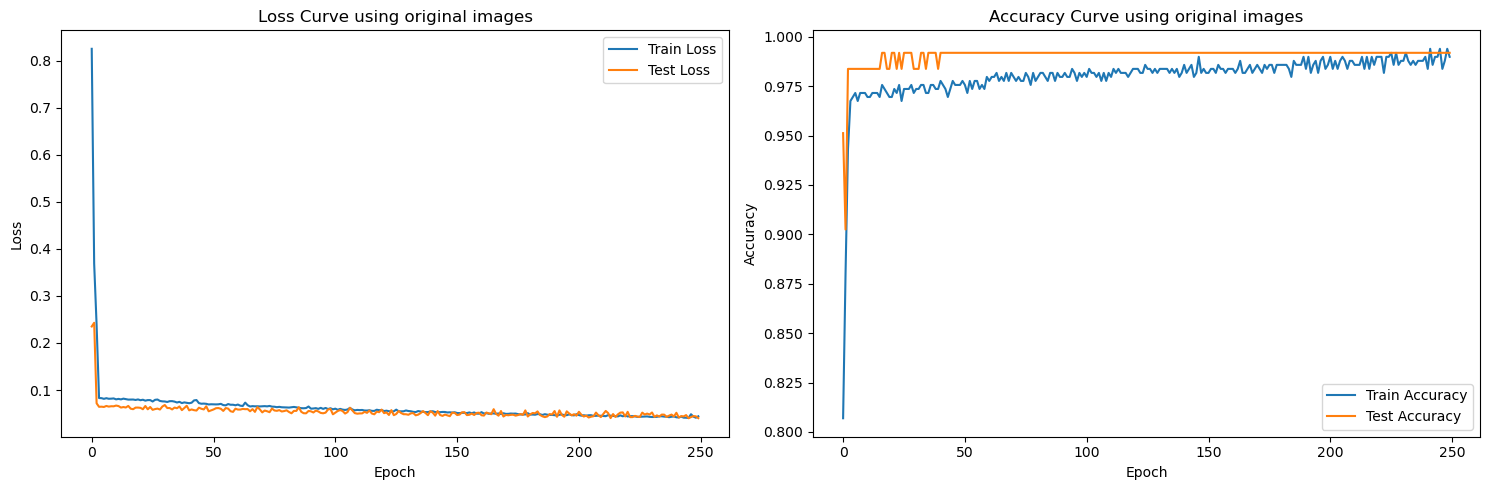

In [18]:
# Now you can plot the results in a new cell
import matplotlib.pyplot as plt

# Assuming `results` is the dictionary returned from the function
train_losses = results['train_losses']
test_losses = results['test_losses']
train_accuracies = results['train_accuracies']
test_accuracies = results['test_accuracies']

plt.figure(figsize=(15, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(range(len(train_losses)), train_losses, label='Train Loss')
plt.plot(range(len(test_losses)), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve using original images')
plt.legend()

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(len(train_accuracies)), train_accuracies, label='Train Accuracy')
plt.plot(range(len(test_accuracies)), test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve using original images')
plt.legend()

plt.tight_layout()
plt.show()


In [17]:
print(f"Best Train Accuracy: {results['best_train_acc']:.4f} at Epoch {results['best_train_epoch']}")
print(f"Best Test Accuracy: {results['best_test_acc']:.4f} at Epoch {results['best_test_epoch']}")

Best Train Accuracy: 0.9939 at Epoch 242
Best Test Accuracy: 0.9919 at Epoch 17


In [ ]:
train_feats.tensors[0].shape[1]

In [ ]:
results